In [1]:
# 기본
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps, edge_adj_mat, C_origin
from dataset.dataset_config import converted_nodes, converted_edges, river_info # only for visualization
from dataset.traffic_dataset import TrafficDataset
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from utils.visualization import plot_mape_violin, visualize_predictions, add_tod_dow, plot_city_edge_mape

from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT
from models.STGCN_with_auxiliary_network_model import STGCNWithAux
from models.STLinear import STLinear
from models.STLinear_deriven import STLinear_HopBiased, STLinear_SPE, compute_spe_torch


c:\Users\Kim Seung Woo\miniconda3\envs\mlproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Kim Seung Woo\miniconda3\envs\mlproject\lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
c:\Users\Kim Seung Woo\miniconda3\envs\mlproject\lib\site-packages\torch_geometric\graphgym\imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [2]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [3]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 64
EPOCHS = 50
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# seed=42
# torch.manual_seed(seed)
# np.random.seed(seed)
# if torch.cuda.is_available():
#     # 현재 GPU에 대한 시드 고정
#     torch.cuda.manual_seed(seed)
#     # 다중 GPU 환경에서도 모두 같은 시드 고정
#     torch.cuda.manual_seed_all(seed)

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

aux_data = np.load('dataset/traffic_dataset_13_aux_smoothen.npy') # (T_aux_total, E, C) (10080, 50, 3)
aux_tensor = torch.from_numpy(aux_data).float().to(DEVICE)

# 2) SPE 텐서 계산 (NumPy 인접행렬 → SPE)
spe_dim = 32
spe_tensor = compute_spe_torch(edge_adj_mat, spe_dim, normalized=True)  # (E, p)
spe_tensor = spe_tensor.to(DEVICE)

In [4]:
# 공통 파라미터 및 모델 목록 정의

DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
#    "GCNMLP":    GCNMLP,
#    "DCRNN":     DCRNN,
#    "STGCN":     STGCN,
#    "MLPBASED":  MLPBASED,
#    "STGAT": STGAT,
#    "STGCNWithAux": STGCNWithAux,
#    "STLinear_h1": STLinear,
#    "STLinear": STLinear
    "STLinear_HopBiased": STLinear_HopBiased,
#    "STLinear_SPE": STLinear_SPE
}

이어서 학습하기

In [5]:
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드
# ─────────────────────────────────────────────────────────

for name, ModelClass in models.items():
    # (1) 모델 재생성 (학습 시와 동일한 인자 사용)
    #    -- 이하 2)~3)은 학습 루프와 동일하게 구성합니다.
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=32, encoder_depth=1,
            dropout=0.0
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        elif name == "STGAT":
            kwargs.update(encoder_depth=2, kernel_size=3, heads=4)
        elif name == "STGCNWithAux":
            kwargs = dict(
                    num_nodes=E,
                    node_feature_dim=5,
                    pred_node_dim=3,
                    encoder_embed_dim=64,
                    aux_embed_dim=64,
                    aux_data=aux_tensor,
                    encoder_depth=3,
            )
        elif name == "STLinear_h1":
            kwargs = dict(num_nodes=50,
                    kernel_size=33,
                    num_layers=6, 
                    num_heads=1,
                    dropout=0.14
            )
        elif name == "STLinear":
            kwargs = dict(num_nodes=50,
                    kernel_size=33,
                    num_layers=6, 
                    num_heads=8,
                    dropout=0.06
            )
        elif name == "STLinear_HopBiased":
            kwargs = dict(
                    num_nodes            = 50,    # 엣지 수
                    kernel_size          = 33,    # 시계열 분해 커널 크기
                    in_steps             = 12,    # 입력 시점 길이
                    out_steps            = 3,     # 예측 시점 길이
                    steps_per_day        = 480,   # 하루 스텝 수
                    input_dim            = 3,     # volume/density/flow
                    output_dim           = 3,     # 예측 채널
                    input_embedding_dim  = 24,    # traffic → 24차원 임베딩
                    tod_embedding_dim    = 24,    # time-of-day 임베딩
                    dow_embedding_dim    = 24,    # day-of-week 임베딩
                    spatial_embedding_dim= 0,     # 원본에서는 사용 안 함
                    adaptive_embedding_dim= 80,   # adaptive embedding 크기
                    feed_forward_dim     = 256,   # FFN hidden dim
                    num_heads            = 2,     # max_hop + 1 = 2, 순수 어텐션 + 홉 bias
                    num_layers           = 6,     # 블록 반복 횟수
                    dropout              = 0.14,  # 드롭아웃 비율
                    use_mixed_proj       = True   # 마지막 예측용 Projection
                )
        elif name == "STLinear_SPE":
            kwargs = dict(
                    num_nodes=50,            # E
                    kernel_size=33,          # 시계열 분해 커널
                    in_steps=12,             # 과거 입력 스텝 (기본)
                    out_steps=3,             # 예측 스텝 (기본)
                    steps_per_day=480,       # 하루 스텝 수 (기본)
                    input_dim=3,             # volume/density/flow
                    output_dim=3,            # 예측 채널
                    # ────────────────────────────────────────
                    # STLinear_h1과 동일한 임베딩 크기
                    input_embedding_dim=24,  # STLinear 기본
                    tod_embedding_dim=24,
                    dow_embedding_dim=24,
                    spatial_embedding_dim=0, # 원본 STLinear_h1에서는 사용 안 함
                    adaptive_embedding_dim=80,
                    # ────────────────────────────────────────
                    # SPE 관련
                    spe_dim=32,              # 고유벡터 개수 (p)
                    spe_out_dim=96,          # SPE → 투영 차원
                    normalized_laplacian=False,
                    # ────────────────────────────────────────
                    # 공간 블록 설정 (STLinear_h1과 동일)
                    feed_forward_dim=256,    # Self-Attention FFN hidden dim
                    num_heads=1,             # max_hop+1 = 1
                    num_layers=6,            # 블록 반복 횟수
                    dropout=0.14,            # 드롭아웃 비율
                    use_mixed_proj=True
            )
        
        model = ModelClass(**kwargs)
        model.to(DEVICE)

    # (2) 가중치 로드 (임시. 나중에 수정해야 함.)
    if name == "STGCNWithAux":
        ckpt_path = os.path.join(SAVE_DIR, f"STGCNWithAux_epoch033_val0.7441.pth")
    else:
        ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
    model = model.to(DEVICE)


--- Visualizing STLinear_HopBiased ---


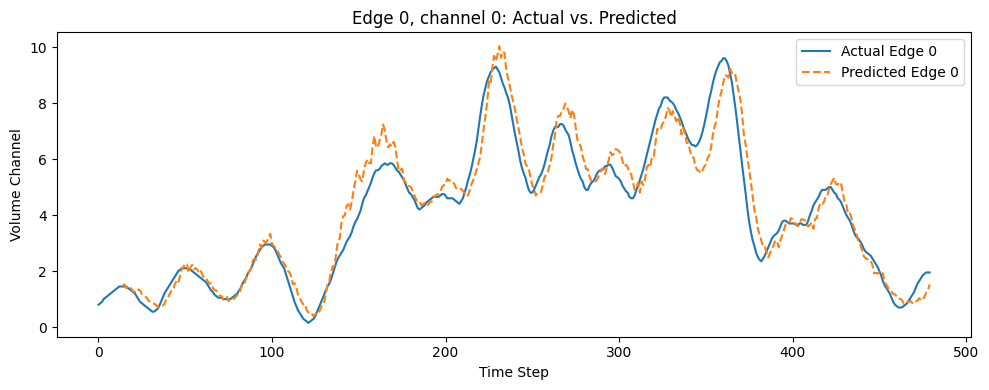

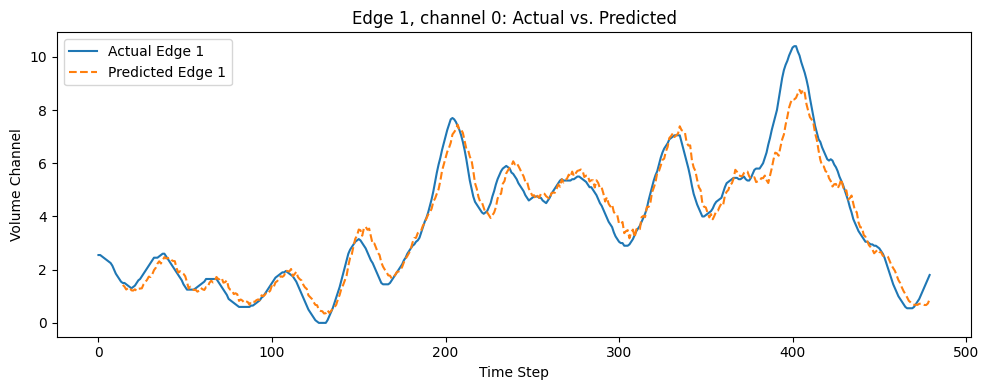

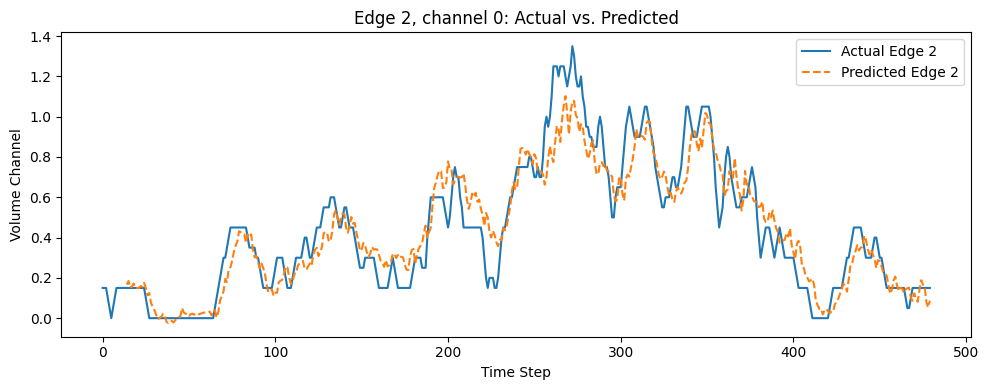

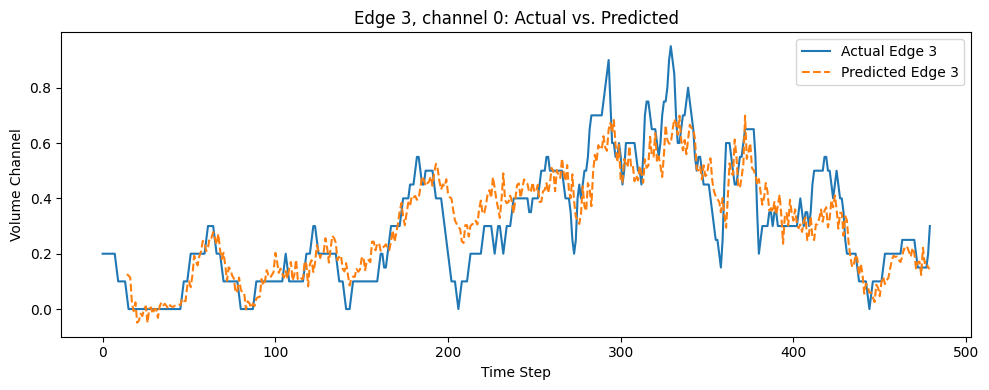

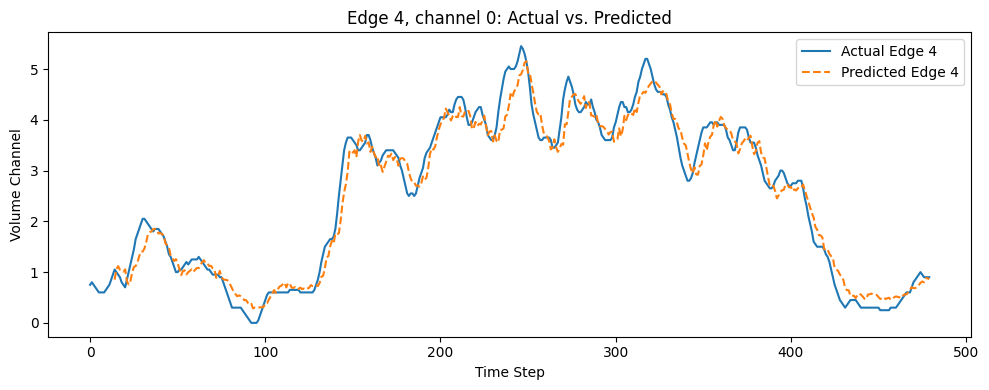

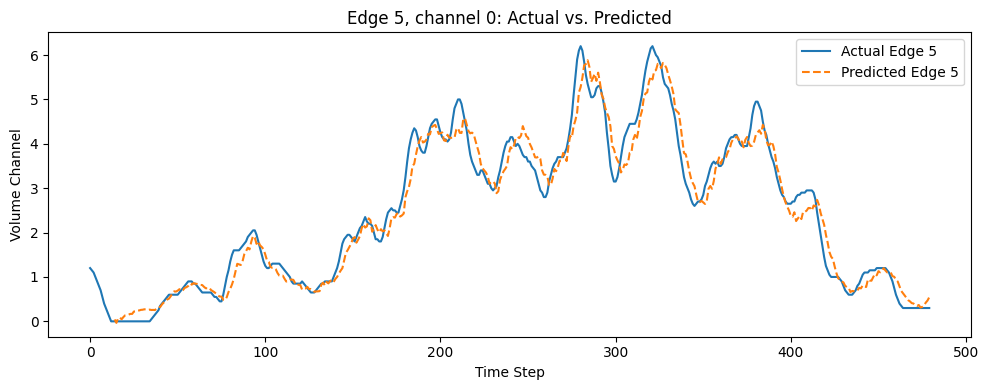

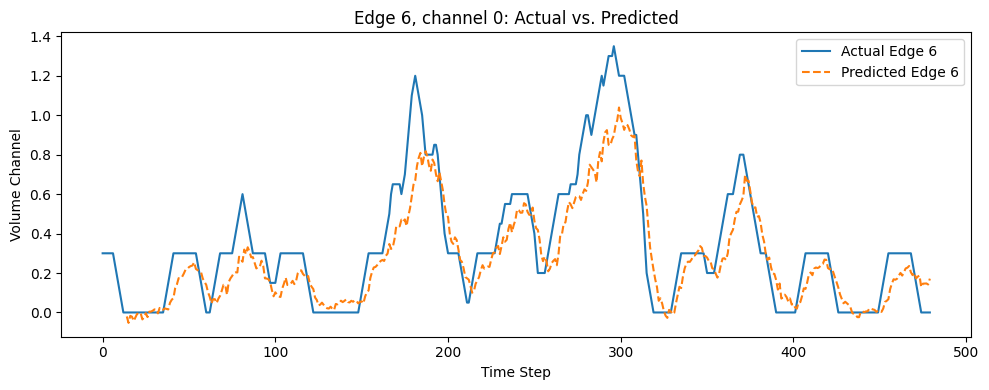

In [6]:
model.to(DEVICE)
print(f"\n--- Visualizing {name} ---")
EDGE_IDS = [0,1,2,3,4,5,6]
expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)

In [7]:
x_batch, y_batch = next(iter(train_loader))  # (B, T, E, D), (B, T_out, E, D_out)
x_input = x_batch[0].unsqueeze(0).to(DEVICE) # B=1로 만듦

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
import networkx as nx


model.eval()

with torch.no_grad():
    output, attention_maps = model(x_input, return_attn=True)  # x_input: (B, T, E, D')


layer0 = attention_maps[3]




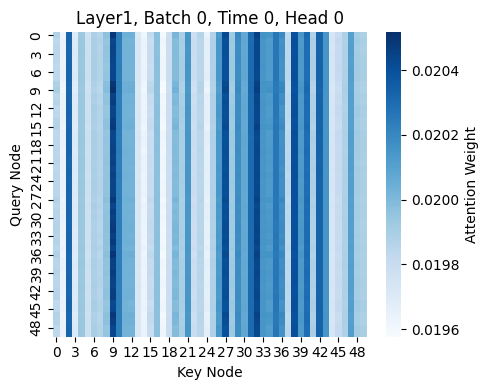

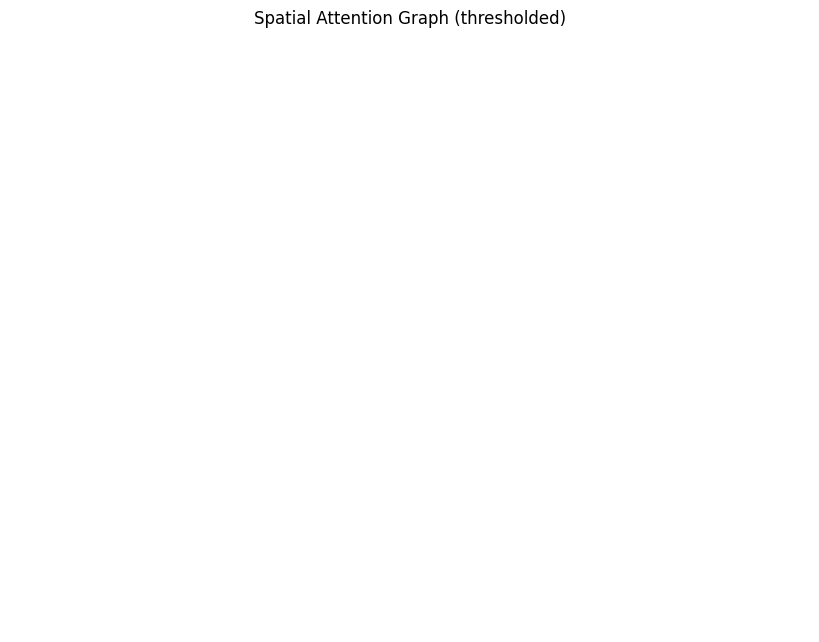

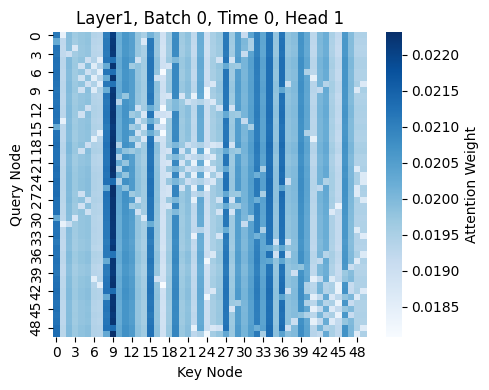

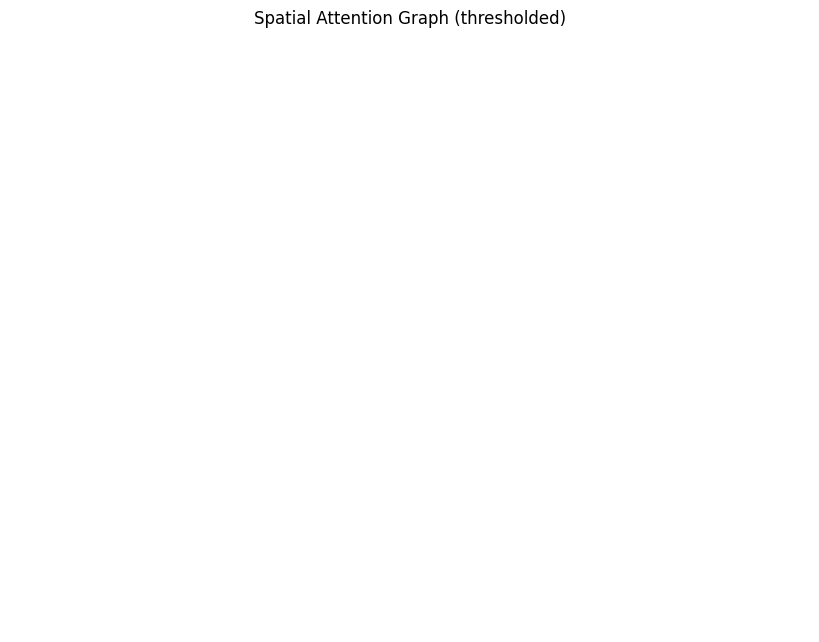

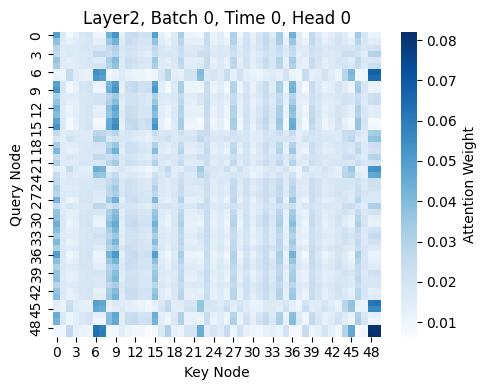

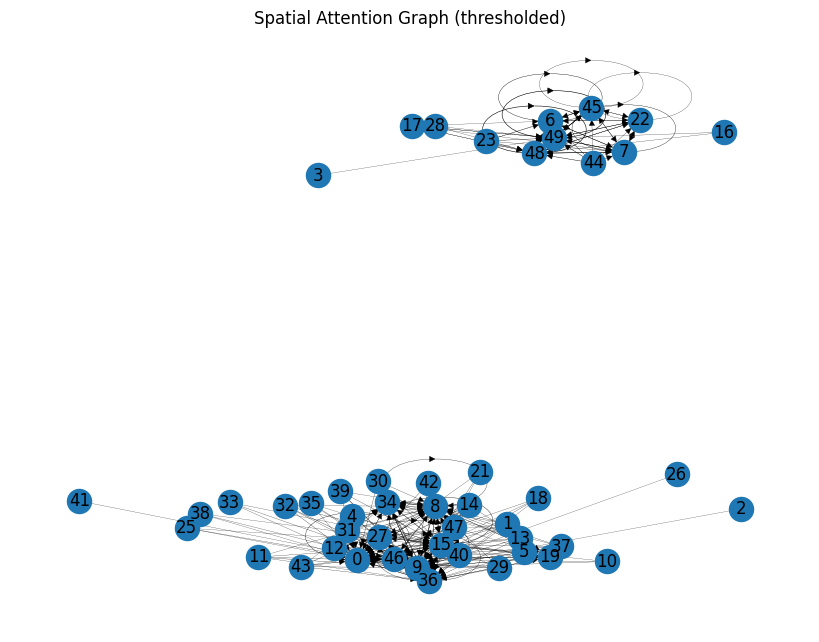

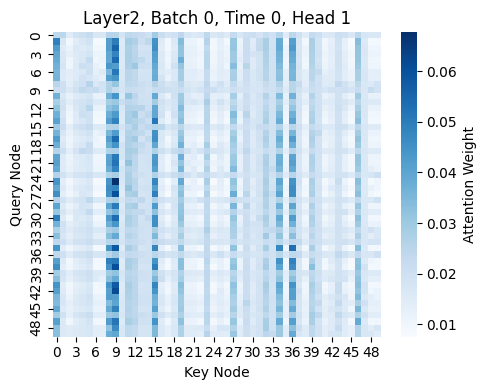

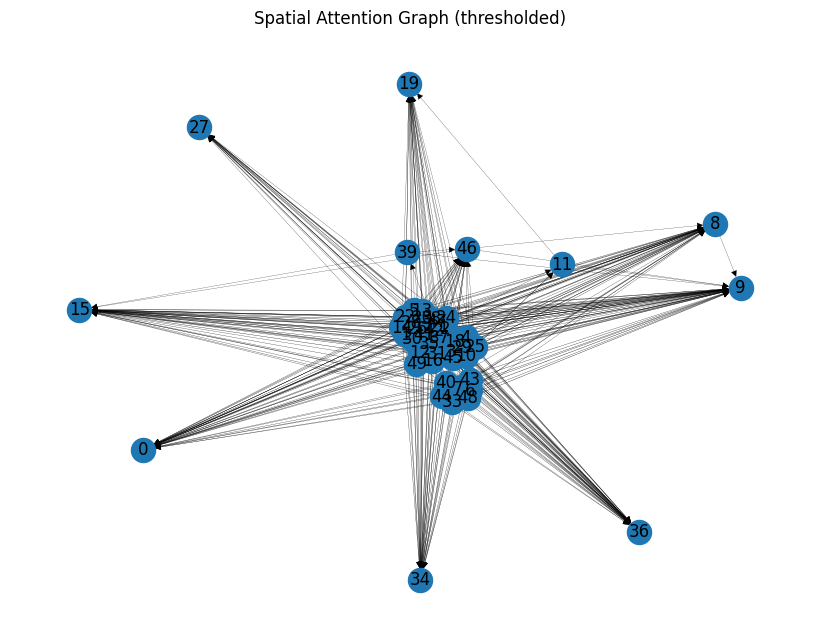

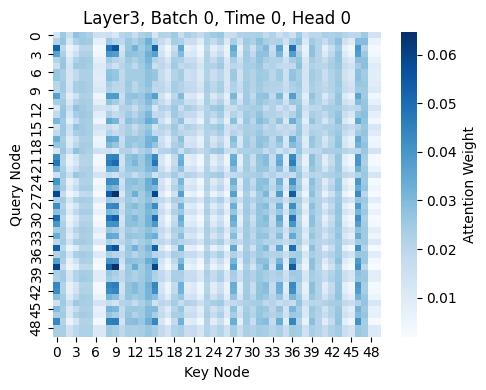

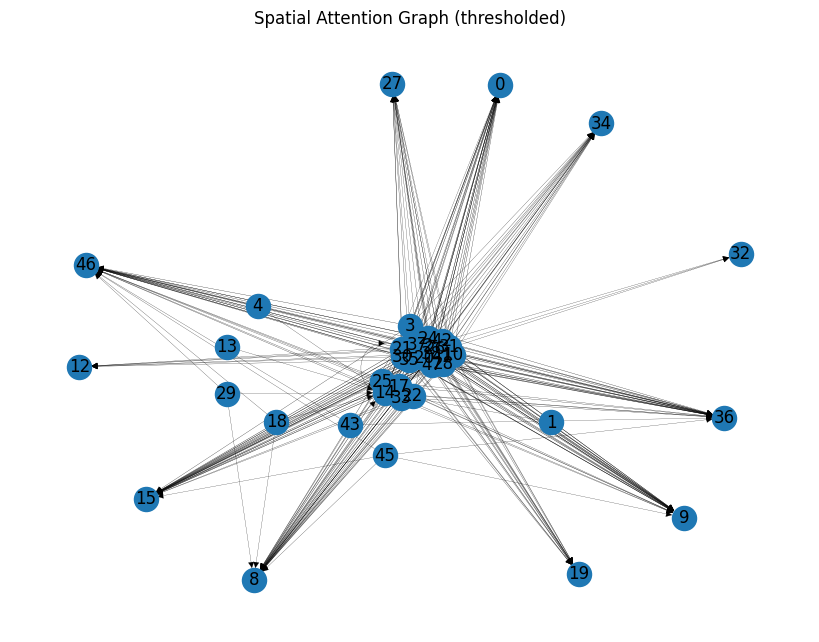

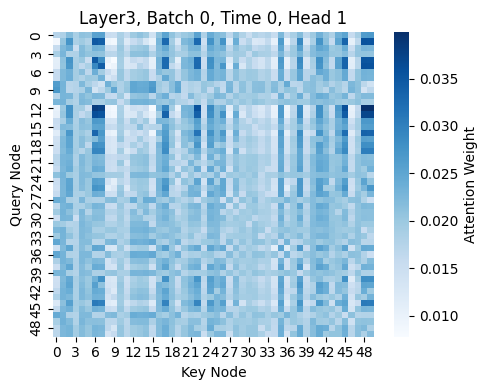

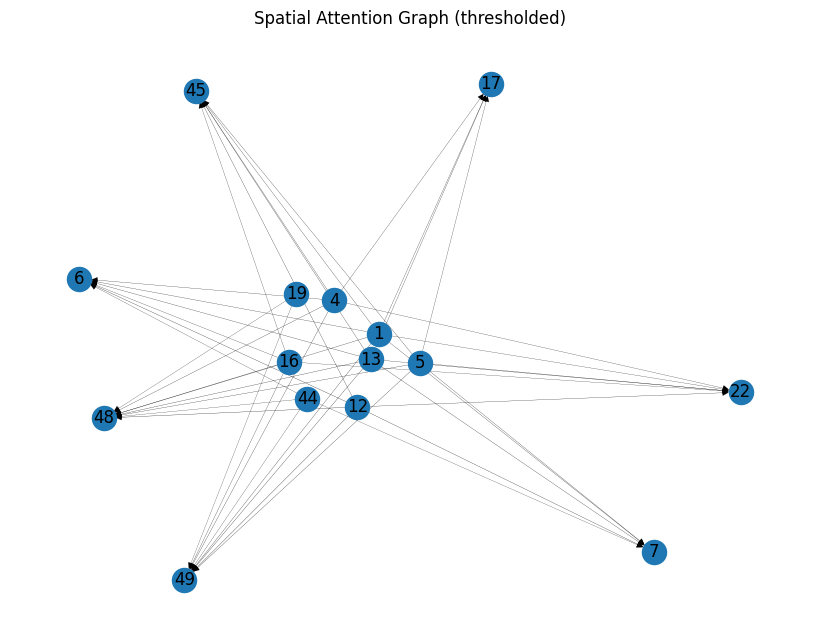

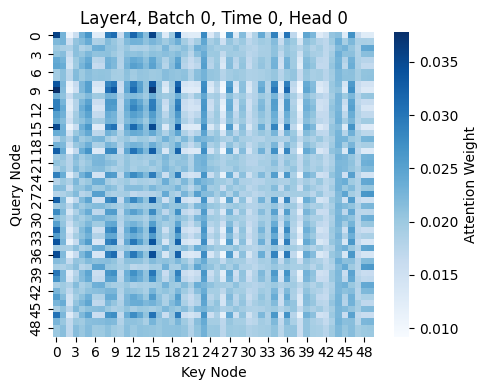

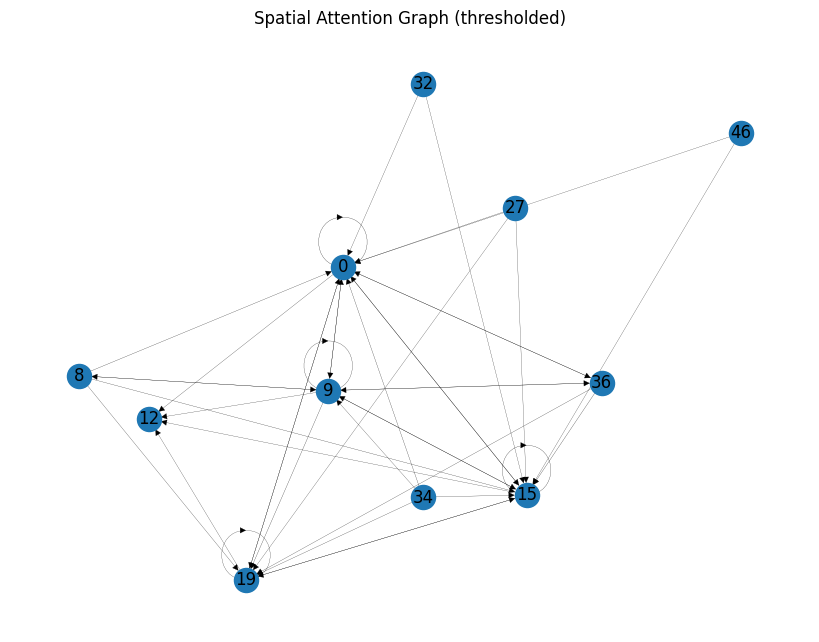

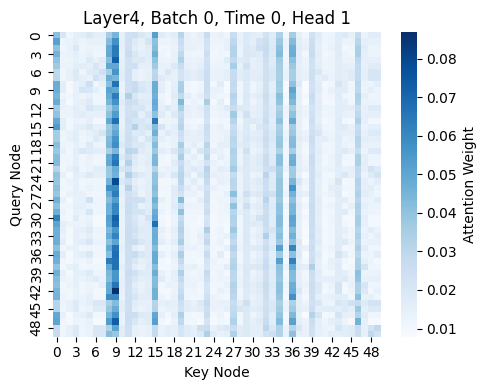

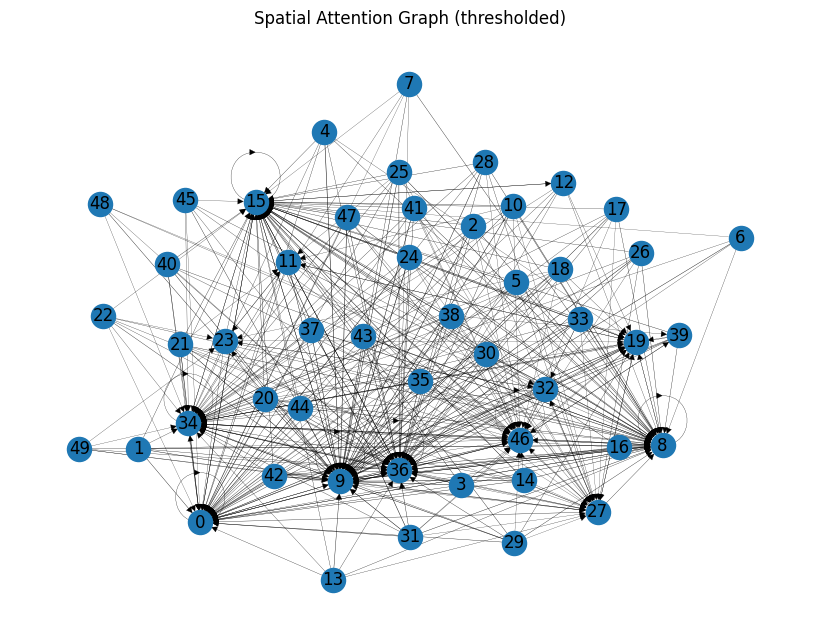

In [ ]:
for k in range(4):
    layer0 = attention_maps[k]

    BT, H, E, _ = layer0.shape


    B = x_input.size(0)               # 배치 크기, 여기선 1
    T = BT // B                       # 타임스텝 수, 여기선 12

    layer = layer0.view(B, T, H, E, E)

    batch_idx = 0
    time_idx = 0


    attn_heads = layer[batch_idx, time_idx]


# attention map 및 Graph 출력

    for h in range(H):
        attn_map = attn_heads[h].cpu().numpy()  # (E, E)
        plt.figure(figsize=(5,4))
        sns.heatmap(attn_map, cmap='Blues', 
                    cbar_kws={'label':'Attention Weight'})
        plt.title(f'Layer{k+1}, Batch {batch_idx}, Time {time_idx}, Head {h}')
        plt.xlabel('Key Node')
        plt.ylabel('Query Node')
        plt.tight_layout()
        plt.show()


        N = attn_map.shape[0]
        G = nx.DiGraph()
        for i in range(N):
            for j in range(N):
                w = attn_map[i,j]
                if w > 0.03:  # threshold
                    G.add_edge(i, j, weight=w)


        pos = nx.spring_layout(G)

        plt.figure(figsize=(8, 6))
        nx.draw(G, pos, with_labels=True,
                width=[G[u][v]['weight']*5 for u,v in G.edges()])

        plt.title("Spatial Attention Graph (thresholded)")
        # 4) 맨 마지막에 show()
        plt.show()

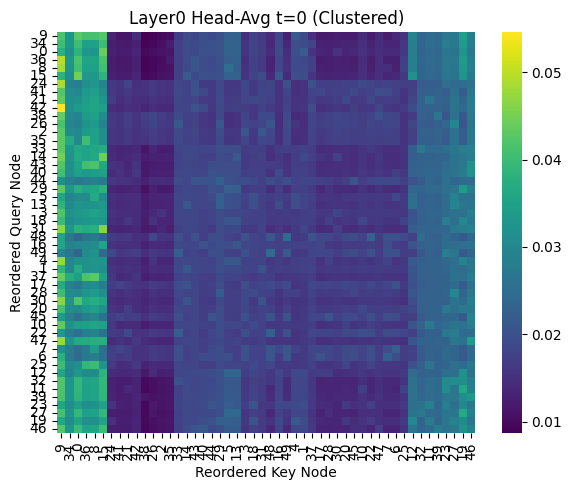

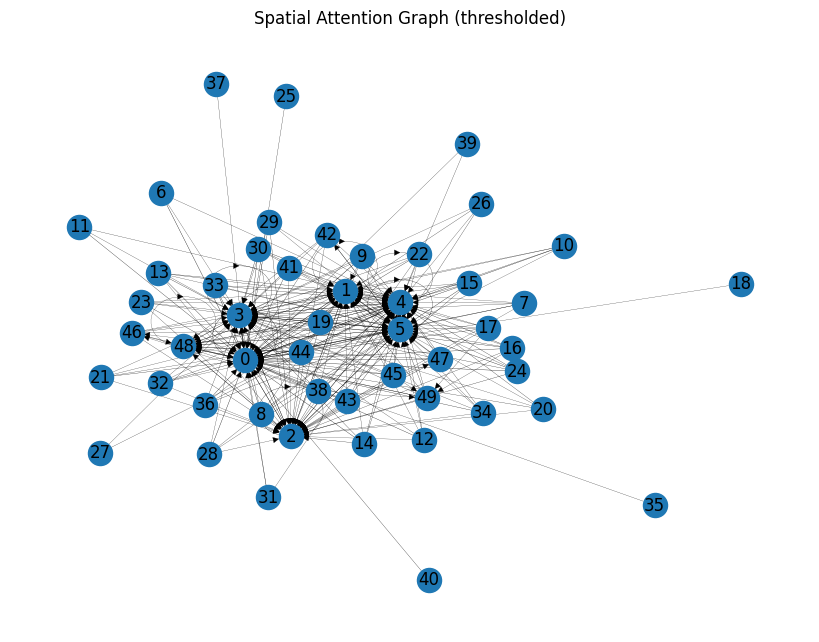

In [32]:

BT, H, E, _ = layer0.shape


B = x_input.size(0)               # 배치 크기, 여기선 1
T = BT // B                       # 타임스텝 수, 여기선 12

layer0 = layer0.view(B, T, H, E, E)


# 2) Aggregation 예시: 
#   a) 헤드 평균 → (B, T, E, E)
#   b) 특정 시점만 뽑기 or 시점 평균 → (B, E, E)
# 아래는 배치0, 시점0에 대해 “헤드 평균”을 취한 맵
attn_heads_avg = layer0[0].mean(dim=1)    # → (T, E, E)
time_idx = 0
attn_agg = attn_heads_avg[time_idx].cpu().numpy()  # (E, E)

# or, 시점 평균까지 함께 하고 싶다면:
# attn_agg = attn_heads_avg.mean(dim=0).cpu().numpy()  # (E, E)

# 3) Clustering: 계층적 군집화로 노드 순서(order) 구하기
#    similarity 로는 각 노드 i의 “전체 주목도”(행 평균)를 사용
sim = attn_agg.mean(axis=0)            # (E,)
Z = linkage(sim.reshape(-1,1), method='average')
order = leaves_list(Z)                 # 군집화된 노드 인덱스 순서

# 4) 재배열된 맵
attn_clustered = attn_agg[order][:, order]

# 5) 시각화
plt.figure(figsize=(6,5))
sns.heatmap(attn_clustered, cmap='viridis', 
            xticklabels=order, yticklabels=order)
plt.title(f'Layer0 Head-Avg t={time_idx} (Clustered)')
plt.xlabel('Reordered Key Node')
plt.ylabel('Reordered Query Node')
plt.tight_layout()
plt.show()
    

# # 예시 시각화: 첫 번째 레이어, 첫 번째 배치, 첫 타임스텝, 헤드 0
# import matplotlib.pyplot as plt
# import seaborn as sns

# attn = attention_maps[2][0, 0, 0].cpu().numpy()  # (E, E)
# sns.heatmap(attn)
# plt.title("Layer 1, Head 0 Attention Map at t=0")
# plt.show()

import networkx as nx

N = attn_clustered.shape[0]
G = nx.DiGraph()
for i in range(N):
    for j in range(N):
        w = attn_clustered[i,j]
        if w > 0.03:  # threshold
            G.add_edge(i, j, weight=w)


pos = nx.spring_layout(G)

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True,
        width=[G[u][v]['weight']*5 for u,v in G.edges()])

plt.title("Spatial Attention Graph (thresholded)")
# 4) 맨 마지막에 show()
plt.show()